In [1]:
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import math
import torch.nn.functional as F
from torch.nn.functional import relu
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import random
import numpy as np
import gc
from pylab import *
import os
import random
import json
import pandas as pd
from scipy.stats import norm
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import sys
import matplotlib.pyplot as plt
import time

from linear_transformer import Transformer_F, attention, generate_data, in_context_loss, generate_data_inplace

np.set_printoptions(precision = 4, suppress = True)
torch.set_printoptions(precision=2)
device = torch.device("cuda")
torch.cuda.set_device(0)

In [2]:
# Set Hyperparameters

# Fixed
n_head = 1
d = 5
B = 1000
ma = 1
var = 0.05
shape_k = 0.1

# We vary the following parameters
n_layer = 3
mode = 'normal'
N = 20
n_sample = 10000 # number of stochastic gradients to sample
seed = 1

log_dir = 'log' 
os.makedirs(log_dir, exist_ok=True)

In [3]:
np.random.seed(seed)
torch.manual_seed(seed)

model = Transformer_F(n_layer, n_head, d, var)
model.to(device)

# compute estimated true gradient using large batch
B_large = B*100
Z, y = generate_data(mode,N,d,B_large,shape_k)
Z = Z.cuda()
y = y.cuda()

# redefine loss using newly sampled Z and y
def eval_loss():
    output = model(Z)
    N= Z.shape[1]-1
    diff = output[:,N,d]+y
    loss = ((diff)**2).mean() 
    loss = loss 
    return loss

loss = eval_loss()
loss.backward()
gradient = model.allparam.grad.data.clone().detach()
model.allparam.grad.zero_()

noiseList = []
for _ in range(n_sample):
    # compute stochastic gradient
    Z, y = generate_data(mode,N,d,B,shape_k)
    Z = Z.cuda()
    y = y.cuda()
    
    loss = in_context_loss(model, Z, y)
    loss.backward()
    stochastic_gradient = model.allparam.grad.data.clone().detach()
    model.allparam.grad.zero_()

    noise = torch.norm(stochastic_gradient - gradient)
    noiseList.append(noise.item())

filename = log_dir + '/stochastic_gradient_noise_layer{}_N{}_{}_sd{}.pth'.format(n_layer,N,mode,seed)
torch.save({'noiseList':noiseList}, filename)

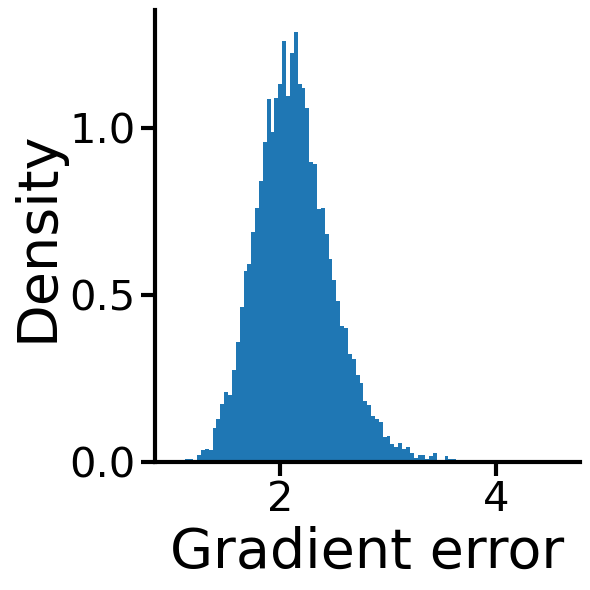

In [6]:
# Plot stochastic gradient noise

import torch
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

fig_dir = 'figures' 
os.makedirs(fig_dir, exist_ok=True)

# hyperparamters
mode = 'normal'
N = 20
seed = 1
n_layer = 3

filename = log_dir + '/stochastic_gradient_noise_layer{}_N{}_{}_sd{}.pth'.format(n_layer,N,mode,seed)
loaded_dict = torch.load(filename)
noiseList = loaded_dict['noiseList']
noiseArray = np.array(noiseList)

fig, ax = plt.subplots(1, 1,figsize = (6, 6))
ax.hist(noiseList, bins=100, density=True, alpha=1.0, edgecolor = 'black', linewidth = 0.001)
ax.tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10)
ax.tick_params(axis='both', which='minor', labelsize=30, width = 3, length = 5)

ax.spines[['right', 'top']].set_visible(False)
ax.spines['left'].set_linewidth(3)
ax.spines['bottom'].set_linewidth(3)
ax.set_ylabel('Density',fontsize=40)
ax.set_xlabel('Gradient error',fontsize=40)

plt.tight_layout()
plt.savefig(fig_dir + '/heavy_tail_noise_layer{}_N{}_{}.pdf'.format(n_layer, N, mode), dpi=600)